### Deep Q learning for Frozen lake using pytorch.
Tasks:
* Complete the code by replacing all instances of "?"
and "your code here" with your implementation.
* Respond to the questions provided at the end of this file.

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F


# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# FrozeLake Deep Q-Learning
class FrozenLakeDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 10          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 1000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error
    optimizer = None                # NN Optimizer. Initialize later.

    ACTIONS = ['L','D','R','U']     # for printing 0,1,2,3 => L(eft),D(own),R(ight),U(p)


    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Get number of input nodes
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent either reached goal (reward=1) or fell into hole (reward=0)
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts an state (int) to a tensor representation.
    For example, the FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15.

    Parameters: state=1, num_states=16
    Return: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    '''
    def state_to_dqn_input(self, state:int, num_states:int)->torch.Tensor:
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor


    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        # Get number of input nodes
        num_states = dqn.fc1.in_features
        best_actions=[]

        symbol_map = {'L': '←', 'D': '↓', 'R': '→', 'U': '↑'}
        # Loop each state and print policy to console
        for s in range(num_states):
            #  Format q values for printing
            q_values = ''
            for q in dqn(self.state_to_dqn_input(s, num_states)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn_input(s, num_states)).argmax()]
            best_actions.append(best_action)

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states
        mapped_results = [symbol_map[action] for action in best_actions]
        print(mapped_results)
        grid_size = int(np.sqrt(num_states))
        policy_grid = np.array(mapped_results).reshape((grid_size, grid_size))

        print("Optimal Policy:")
        for row in policy_grid:
            print(" ".join(row))

        plt.figure(figsize=(5, 5))
        plt.table(cellText=policy_grid, cellLoc='center', loc='center', cellColours=[['w'] * grid_size] * grid_size)
        plt.axis('off')
        plt.show()



    # Train the FrozeLake environment
    def train(self, episodes, render=False, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human' if render else None)

        num_states = ?
        num_actions = ?

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        print('Policy (random, before training):')
        self.print_dqn(policy_dqn)

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = np.zeros(episodes)

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0

        for i in range(episodes):
            state = ?  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if ?
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action in the env
                your code here

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                your code here

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            if reward == 1:
                rewards_per_episode[i] = 1

            # Check if enough experience has been collected and if at least 1 reward has been collected
            if len(memory)>self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()

        # Save policy
        torch.save(policy_dqn.state_dict(), "frozen_lake_dql.pt")



    # Run the FrozeLake environment with the learned policy
    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode=None)
        num_states = ?
        num_actions = ?

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dql.pt"))
        policy_dqn.eval()    # switch model to evaluation mode

        print('Policy (trained):')
        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state = ?  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                your code here

        env.close()



Policy (random, before training):
00,U,[+0.11 +0.19 -0.23 +0.31] 01,U,[+0.27 +0.20 -0.25 +0.34] 02,U,[+0.30 +0.18 -0.29 +0.31] 03,U,[+0.33 +0.20 -0.26 +0.39] 
04,D,[+0.12 +0.19 -0.07 +0.19] 05,U,[+0.21 +0.16 -0.16 +0.36] 06,U,[+0.19 +0.22 -0.32 +0.29] 07,U,[+0.14 +0.21 -0.16 +0.22] 
08,U,[+0.08 +0.12 -0.03 +0.19] 09,U,[+0.12 +0.10 -0.12 +0.19] 10,U,[+0.17 +0.22 -0.25 +0.28] 11,U,[+0.23 +0.17 -0.16 +0.23] 
12,U,[+0.09 +0.22 -0.24 +0.30] 13,U,[+0.16 +0.17 -0.24 +0.41] 14,U,[+0.19 +0.17 -0.24 +0.22] 15,U,[+0.18 +0.27 -0.27 +0.32] 
['↑', '↑', '↑', '↑', '↓', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']
Optimal Policy:
↑ ↑ ↑ ↑
↓ ↑ ↑ ↑
↑ ↑ ↑ ↑
↑ ↑ ↑ ↑


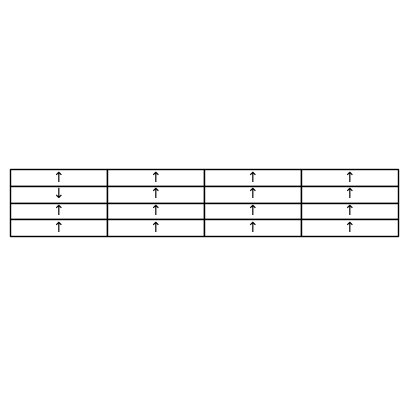

Policy (trained):
00,D,[+0.49 +0.59 +0.59 +0.55] 01,R,[+0.54 +0.06 +0.65 +0.58] 02,D,[+0.60 +0.73 +0.54 +0.68] 03,L,[+0.66 +0.11 +0.49 +0.60] 
04,D,[+0.59 +0.65 +0.01 +0.52] 05,U,[+0.57 +0.54 +0.70 +0.72] 06,D,[+0.04 +0.81 -0.01 +0.57] 07,D,[+0.56 +0.58 +0.53 +0.50] 
08,R,[+0.67 -0.01 +0.73 +0.58] 09,R,[+0.64 +0.81 +0.81 +0.02] 10,D,[+0.73 +0.90 +0.01 +0.73] 11,R,[+0.67 +0.44 +0.68 +0.54] 
12,U,[+0.38 +0.65 +0.39 +0.71] 13,R,[+0.17 +0.81 +0.90 +0.63] 14,R,[+0.80 +0.88 +1.00 +0.79] 15,U,[+0.51 +0.55 +0.48 +0.71] 
['↓', '→', '↓', '←', '↓', '↑', '↓', '↓', '→', '→', '↓', '→', '↑', '→', '→', '↑']
Optimal Policy:
↓ → ↓ ←
↓ ↑ ↓ ↓
→ → ↓ →
↑ → → ↑


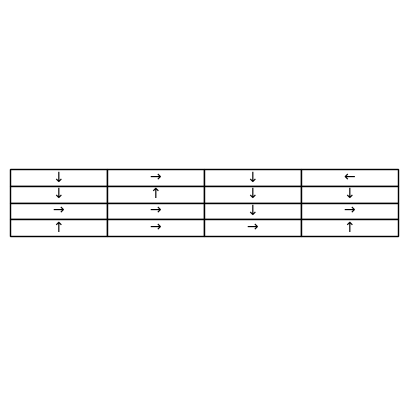

In [2]:
frozen_lake = FrozenLakeDQL()
is_slippery = False
frozen_lake.train(1000, is_slippery=is_slippery)
frozen_lake.test(10, is_slippery=is_slippery)

Questions:
1. What is the purpose of ReplayMemory? What types of information are stored in the replay memory? Why is deque used for implementing it?

2. Why do we use a target network in Deep Q-Learning? How is the target network updated in this implementation? What is the purpose of variable "network_sync_rate" in the code?

3. How are training samples generated for learning? When is an experience added to the replay memory.

4. How are batches of training samples selected from the replay memory? Is the sampling random or sequential? Why?

5. What is the role of the epsilon-greedy policy? How does epsilon change over time in the code, and why is this important?

6. Describe what happens during one training step. How are the Q-values updated using the neural network?